In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Importing the required libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from keras import applications
from keras.callbacks import ModelCheckpoint,EarlyStopping
from PIL import Image
from IPython.display import display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns 

2024-03-11 10:14:40.853959: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 10:14:40.854086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 10:14:40.987532: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Importing the Datasets as genrators, and setting the batch size = 32, Image size = (256,256)

In [2]:
# generators

# Trainning Dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/plant-village-dataset-updated/Apple/Train',
    labels='inferred',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(256,256)
)

# Validation Dataset
val_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/plant-village-dataset-updated/Apple/Val',
    labels='inferred',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(256,256)
)

# Testing Dataset
test_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/plant-village-dataset-updated/Apple/Test',
    labels='inferred',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(256,256),
    shuffle = False
)

Found 7771 files belonging to 4 classes.
Found 1747 files belonging to 4 classes.
Found 196 files belonging to 4 classes.


In [3]:
# Getting the true labels in test_ds for future comparision
y_test = []
for img,labels in test_ds:
    for row in labels:
        y_test.append((np.argmax(row)))
y_test = np.array(y_test)

Function to generate sample from our datasets.

In [4]:
# Function to convert tensor to image
def tensor_to_image(tensor,label,Class_values):

    # Converting tensor into np.array
    tensor = np.array(tensor, dtype=np.uint8)

    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]

    display(Image.fromarray(tensor))

# Function for getting sample
def get_sample(data_ds,n):

  Class_dict = { k:v for (k,v) in zip([i for i in range(0,len(data_ds.class_names))],data_ds.class_names)}

  # Getting a sample batch of 32.
  sample,label = next(iter(train_ds.take(1)))

  for i in range(n):
    print('Type:',Class_dict[np.argmax(label[i])],'|','label is',np.argmax(label[i]))
    tensor_to_image(sample[i],label[i],Class_dict)

Type: Healthy | label is 3


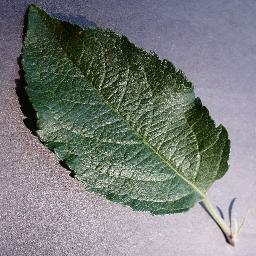

Type: Black Rot | label is 1


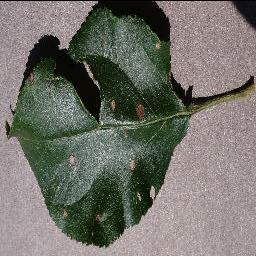

In [5]:
# Generating Two samples from the training Dataset
get_sample(train_ds,2)

Normalizing the images

In [6]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)
test_ds = test_ds.map(process)

In [7]:
# Creating a model checkpoint classback to store the best weights for the model.
checkpoint_filepath = '/tmp/ckpt/checkpoint.weights.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Constructing a CNN model using the sequential api of keras.

In [8]:
# CNN Model 

model3 = Sequential()

model3.add(Conv2D(32,kernel_size=(3,3),padding='same',activation='relu',input_shape=(256,256,3)))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model3.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model3.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model3.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model3.add(Flatten())

model3.add(Dense(128,activation='relu'))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())
model3.add(Dense(64,activation='relu'))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())
model3.add(Dense(64,activation='relu'))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())
model3.add(Dense(4,activation='softmax'))

model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model3.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           25

 Total params: 3,831,556 (14.62 MB)

 Trainable params: 3,830,468 (14.61 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [9]:
history = model3.fit(train_ds,epochs=20,validation_data=val_ds,callbacks = [model_checkpoint_callback])

Epoch 1/20
  2/243 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.3203 - loss: 1.8569   

I0000 00:00:1710152125.337790     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710152125.363278     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7418 - loss: 0.6796

W0000 00:00:1710152157.612742     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


243/243 ━━━━━━━━━━━━━━━━━━━━ 62s 156ms/step - accuracy: 0.7422 - loss: 0.6786 - val_accuracy: 0.3045 - val_loss: 4.5012
Epoch 2/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.9289 - loss: 0.2200 - val_accuracy: 0.3412 - val_loss: 4.0239
Epoch 3/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.9558 - loss: 0.1409 - val_accuracy: 0.9794 - val_loss: 0.0579
Epoch 4/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.9665 - loss: 0.1056 - val_accuracy: 0.9554 - val_loss: 0.1336
Epoch 5/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.9685 - loss: 0.0907 - val_accuracy: 0.9668 - val_loss: 0.0915
Epoch 6/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.9784 - loss: 0.0704 - val_accuracy: 0.9662 - val_loss: 0.1022
Epoch 7/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.9807 - loss: 0.0548 - val_accuracy: 0.9845 - val_loss: 0.0450
Epoch 8/20
243/243 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.9793 - loss: 0.0582 - val_accura

Getting the best weight for the model, i.e. weights for which the model performs the best

In [10]:
model3.load_weights(checkpoint_filepath)

Function to plot accuracy and loss for the model. 

In [11]:
# Function to plot the accurary and loss graphs.
def acc_loss_plts(history):
    
    # summarize history for accuracy
    plt.figure(figsize=(17,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.tight_layout()
    plt.show()

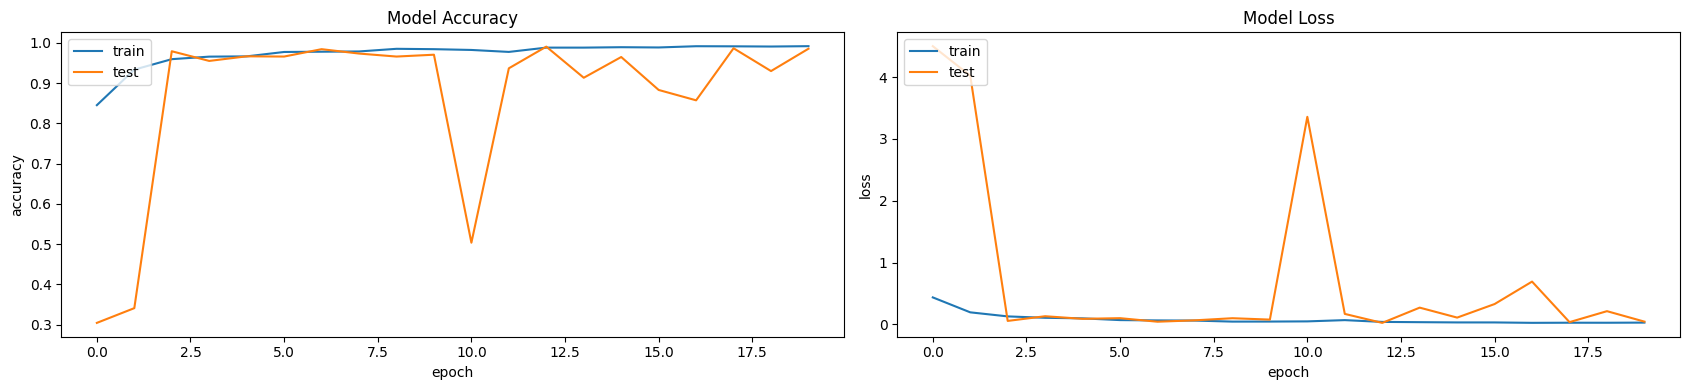

In [12]:
acc_loss_plts(history)

Getting the Perfomance Metrics for Training, Validation and Testing datasets.

In [13]:
# Training Dataset
loss , accuracy = model3.evaluate(train_ds)
print("Accuracy is == ",accuracy)
print("Loss is == ",loss)

243/243 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9973 - loss: 0.0114
Accuracy is ==  0.9962681531906128
Loss is ==  0.012945770286023617


In [14]:
# Validation dataset
loss , accuracy = model3.evaluate(val_ds)
print("Accuracy is == ",accuracy)
print("Loss is == ",loss)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9936 - loss: 0.0203
Accuracy is ==  0.9908414483070374
Loss is ==  0.025861872360110283


In [15]:
# Testing Dataset
loss , accuracy = model3.evaluate(test_ds)
print("Accuracy is == ",accuracy)
print("Loss is == ",loss)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - accuracy: 0.9904 - loss: 0.0243
Accuracy is ==  0.9846938848495483
Loss is ==  0.03548004478216171


Function to plot accuracy and loss for the model. 

In [16]:
# getting the predictions form the model
predictions = model3.predict(test_ds)

predictions = np.argmax(predictions,axis=1)

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

W0000 00:00:1710152504.574447     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


In [17]:
# Classification Report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        51
           1       1.00      0.98      0.99        50
           2       0.98      0.98      0.98        44
           3       1.00      0.98      0.99        51

    accuracy                           0.98       196
   macro avg       0.98      0.98      0.98       196
weighted avg       0.99      0.98      0.98       196



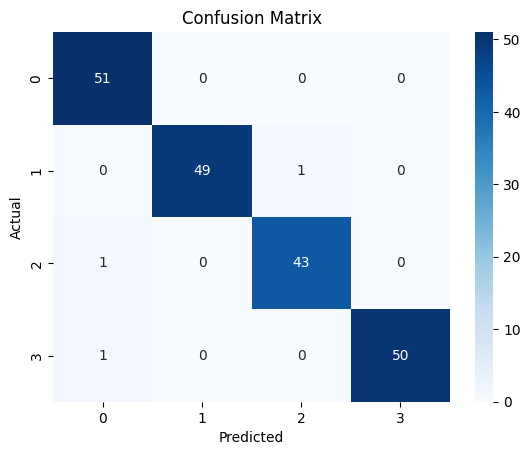

In [18]:
# Plotting the confusion matrix 
sns.heatmap(data=confusion_matrix(y_test,predictions),
            annot=True, fmt='',cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The model shows very promising result for the dataset.